In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

In [2]:
# Import pyMC3 and also arviz for visualisation
import pymc as pm
import arviz as az
import sympy as sp
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('bmh')

RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
fy,yuud,ytd, u, T, delta = sp.symbols('fy,Y_uud,Y_td, u, T, delta')
eq_fy = sp.Eq(fy,yuud*u**2*delta + ytd*T*delta)
eq_fy

Eq(fy, T*Y_td*delta + Y_uud*delta*u**2)

In [4]:
lambda_fy = sp.lambdify(list(eq_fy.rhs.free_symbols), eq_fy.rhs)

## Data

In [46]:
# Size of dataset
size = 20

data = pd.DataFrame()
# Predictor variable
data['delta'] = np.linspace(0,np.deg2rad(10),size)
data['u'] = 0.1
data['T'] = 0.1

# Simulate outcome variable
ytd_=0.5
yuud_=0.2

data['fy'] = lambda_fy(Y_uud=yuud_, Y_td=ytd_, u=data['u'], delta=data['delta'], T=data['T'])

sigma_=0.1*data['fy'].abs().max()
data['fy_measure'] = data['fy'] + rng.normal(size=size) * sigma_

In [47]:
variables = [u,T,delta]
features = eq_fy.rhs.free_symbols - set(variables)
A_,b_ = sp.linear_eq_to_matrix(eq_fy, features)
A_

Matrix([[-T*delta, -delta*u**2]])

In [48]:
features

{Y_td, Y_uud}

In [49]:
lambda_features = sp.lambdify(list(A_.free_symbols),A_)
lambda_labels = sp.lambdify(list(b_.free_symbols),b_)

In [50]:
columns =[symbol.name for symbol in features]
X = pd.DataFrame(lambda_features(T=data['T'], delta=data['delta'], u=data['u'])[0].T, columns=columns, index=data.index)

In [51]:
y = pd.Series(lambda_labels(data['fy']).flatten(), index=data.index)

In [52]:
features

{Y_td, Y_uud}

In [53]:
columns

['Y_td', 'Y_uud']

In [62]:
mus = {
    'Y_uud':yuud_,
    'Y_td':ytd_,
}

stds = {
    'Y_uud':0.01,
    'Y_td':0.01,
}



In [63]:
basic_model = pm.Model()

sigmas_ = [stds[key] for key in columns]
mus_ = [mus[key] for key in columns]

with basic_model:
    # Priors for unknown model parameters
    parameters = pm.Normal("parameters", mu=mus_, 
                           sigma=sigmas_, 
                           shape=len(mus))
    
    sigma = pm.HalfNormal("sigma", sigma=sigma_)

    # Expected value of outcome
    mu = pm.math.dot(X, parameters)

    # Likelihood (sampling distribution) of observations
    #fy_obs = pm.Normal("fy_obs", mu=mu, sigma=sigma, observed=data['fy_measure'])
    ν = pm.Uniform("ν", 1, 10)
    Y_obs = pm.StudentT("fy_obs", nu=ν, mu=mu, sigma=sigma, observed=data['fy_measure'])
    

In [64]:
with basic_model:
    # draw 1000 posterior samples
    trace = pm.sample(draws=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [parameters, sigma, ν]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 4 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


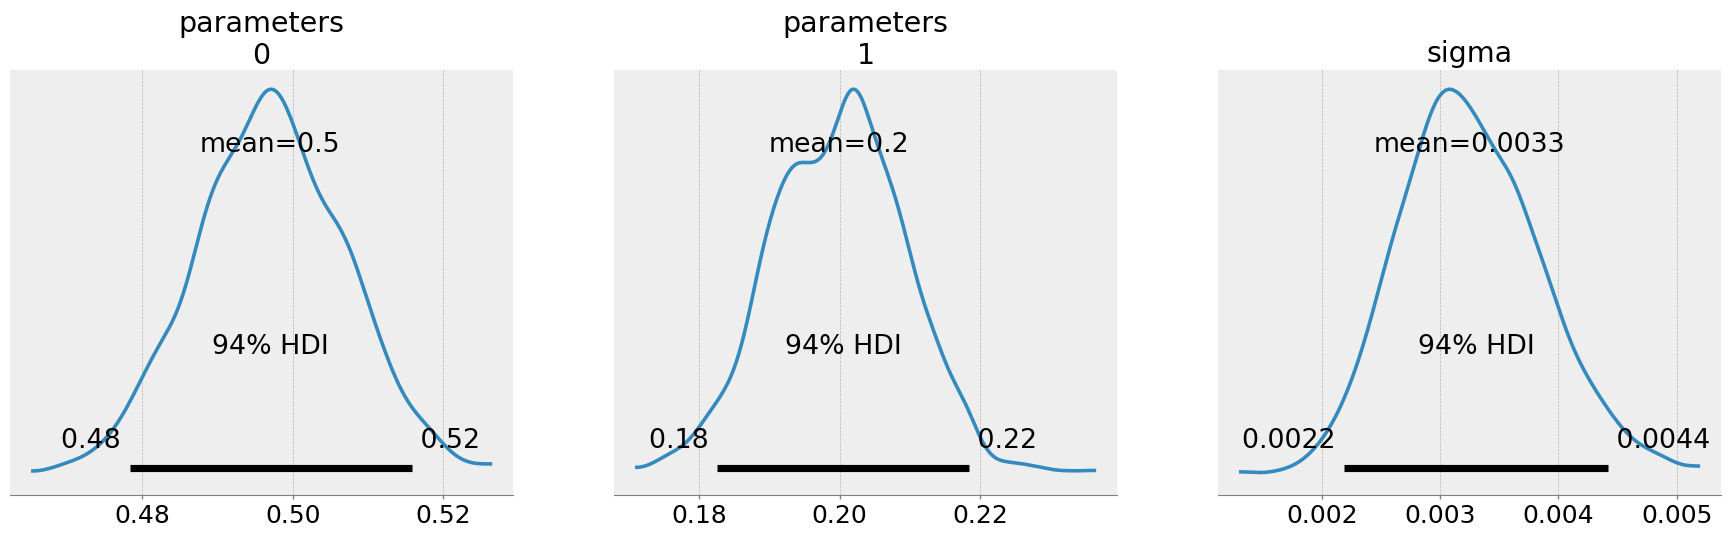

In [65]:
with basic_model:
    az.plot_posterior(trace,
                  var_names=['parameters','sigma'],
                  textsize=18,
                  point_estimate='mean',
                  rope_color='black')

In [66]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
parameters[0],0.497,0.010,0.478,0.516,0.000,0.000,2272.0,1417.0,1.0
parameters[1],0.200,0.010,0.183,0.218,0.000,0.000,1789.0,1348.0,1.0
sigma,0.003,0.001,0.002,0.004,0.000,0.000,1791.0,1428.0,1.0
ν,1.371,0.458,1.000,1.984,0.012,0.009,1413.0,856.0,1.0


In [67]:
means = (trace.posterior['parameters'].data[0].mean(axis=0) + trace.posterior['parameters'].data[1].mean(axis=0))/2
means = {key:mean for key,mean in zip(columns,means)}

In [68]:
data['Bayesian'] = lambda_fy(Y_uud=means['Y_uud'], Y_td=means['Y_td'], u=data['u'], delta=data['delta'], T=data['T'])

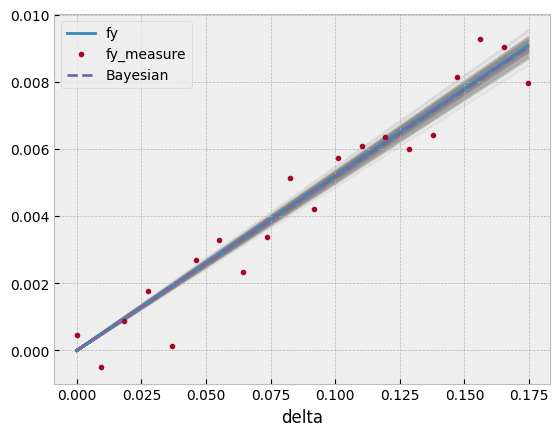

In [69]:
fig,ax=plt.subplots()
data.plot(x='delta', y='fy', ax=ax)
data.plot(x='delta', y='fy_measure', style='.', ax=ax)
data.plot(x='delta', y='Bayesian', style='--', ax=ax)

for params in trace.posterior['parameters'][0].data[0::10]:
    param = {key:mean for key,mean in zip(columns,params)}
    ax.plot(data['delta'],lambda_fy(Y_uud=param['Y_uud'], Y_td=param['Y_td'], u=data['u'], delta=data['delta'], T=data['T']), alpha=0.1, color='grey', zorder=-10)